In [41]:
import matplotlib.pyplot as plt
import matplotlib.dates
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [2]:
df = pd.read_csv("/home/jose/Programming/aiml/Data/houston-AQI-weather/filled-in-data/Oyster Creek C1607.csv")
del df['Unnamed: 0']

df.head(5)

,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,visibility,wind_speed
0,2017-01-01,31,20.121739,17.578261,1011.065217,13311.826087,2.618182
1,2017-01-02,39,22.243478,17.991304,1010.547826,13714.173913,4.960000
2,2017-01-03,45,17.178261,10.843478,1014.776190,11859.869565,2.457143
3,2017-01-04,16,11.856522,5.769565,1018.547826,16093.000000,4.136364
4,2017-01-05,11,12.904348,9.900000,1013.213043,14833.652174,3.000000


In [3]:
x_axis = (matplotlib.dates.datestr2num(df.Date.values))

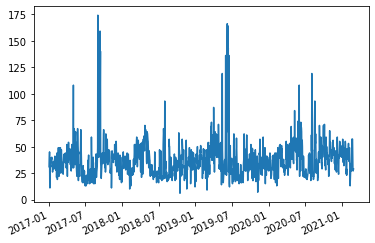

In [4]:
plt.plot_date(x_axis, df.AQI.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

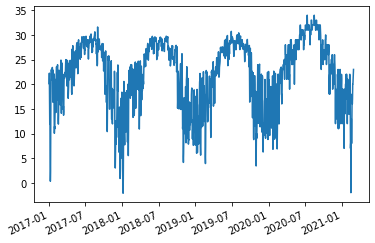

In [12]:
plt.plot_date(x_axis, df.air_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

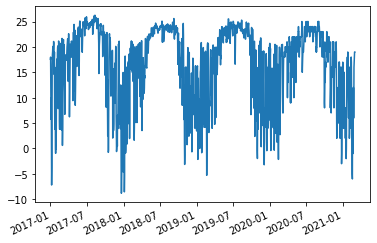

In [13]:
plt.plot_date(x_axis, df.dew_point_temp.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

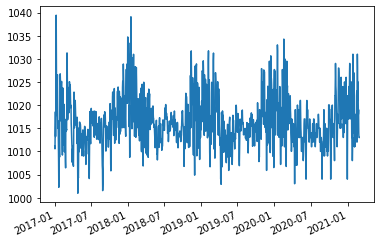

In [14]:
plt.plot_date(x_axis, df.sea_level_pressure.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

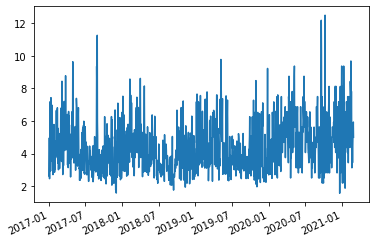

In [15]:
plt.plot_date(x_axis, df.wind_speed.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

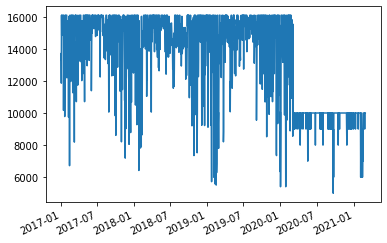

In [5]:
plt.plot_date(x_axis, df.visibility.values, '-')
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

In [3]:
del df['visibility']

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

df['Day'] = df.Date.dt.dayofyear - 1
df['Year'] = df.Date.dt.year - 2017

df.head()

,Date,AQI,air_temp,dew_point_temp,sea_level_pressure,wind_speed,Day,Year
0,2017-01-01,31,20.121739,17.578261,1011.065217,2.618182,0,0
1,2017-01-02,39,22.243478,17.991304,1010.547826,4.960000,1,0
2,2017-01-03,45,17.178261,10.843478,1014.776190,2.457143,2,0
3,2017-01-04,16,11.856522,5.769565,1018.547826,4.136364,3,0
4,2017-01-05,11,12.904348,9.900000,1013.213043,3.000000,4,0


In [5]:
x_data = df[['air_temp', 'dew_point_temp', 'sea_level_pressure', 'wind_speed']].values
y_data = df.AQI.values

print(x_data)

[[  20.12173913   17.57826087 1011.06521739    2.61818182]
 [  22.24347826   17.99130435 1010.54782609    4.96      ]
 [  17.17826087   10.84347826 1014.77619048    2.45714286]
 ...
 [  21.           18.         1014.            5.3125    ]
 [  22.           19.         1013.            5.9375    ]
 [  23.           19.         1013.            5.        ]]


In [6]:
train_test_split = 0.9

num_train = int(len(x_data) * train_test_split)
num_test = len(x_data) - num_train

x_train = x_data[0:num_train]
x_test = x_data[num_train:]

# Expanding dimension to (None, 1) (to a vector) instead of just an array of shape (None,)
# Used in order to feed into the MinMaxScaler (does not support 1D arrays)
y_train = np.expand_dims(y_data[:num_train], axis=1)
y_test = np.expand_dims(y_data[num_train:], axis=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(y_train)

(1368, 4) (152, 4) (1368, 1) (152, 1)
[[31]
 [39]
 [45]
 ...
 [40]
 [43]
 [51]]


In [7]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(y_train)

[[31]
 [39]
 [45]
 ...
 [40]
 [43]
 [51]]


In [29]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input features
        x_shape = (batch_size, sequence_length, x_train.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output
        y_shape = (batch_size, sequence_length, 1)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [30]:
batch_size = 32
# 7 days in a week, 16 times
sequence_length = 7 * 16

generator = batch_generator(batch_size, sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape, y_batch.shape)

(32, 112, 4) (32, 112, 1)


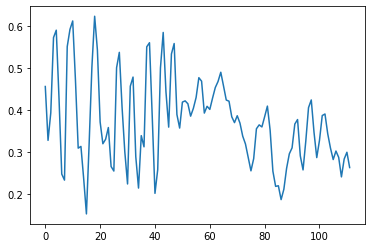

In [31]:
plt.plot(x_batch[0, :, 2])


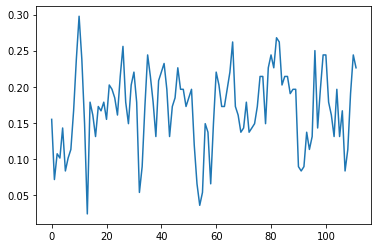

In [31]:
plt.plot(y_batch[1, :, 0])

In [32]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [82]:
model = Sequential()

model.add(
    Bidirectional(
    LSTM(units=512 * 2,
              return_sequences=True,
              input_shape=(None, x_test.shape[1],),
    )
    )
)
    
model.add(Dense(1, activation='sigmoid')) 

In [34]:
warmup_steps = 12

def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [83]:
model.compile(loss=loss_mse_warmup, optimizer=RMSprop(lr=1e-3))

In [84]:
model.fit(x=generator,
            epochs=200,
            steps_per_epoch=100,
            validation_data=validation_data)

068
Epoch 18/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0042 - val_loss: 0.0086
Epoch 19/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0035 - val_loss: 0.0126
Epoch 20/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0031 - val_loss: 0.0061
Epoch 21/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 22/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0024 - val_loss: 0.0069
Epoch 23/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0021 - val_loss: 0.0060
Epoch 24/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 25/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 26/200
100/100 [==============================] - 25s 246ms/step - loss: 0.0015 - val_loss: 0.0061
Epoch 27/200
100/100 [=============================

In [85]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(1):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.legend()
        plt.show()

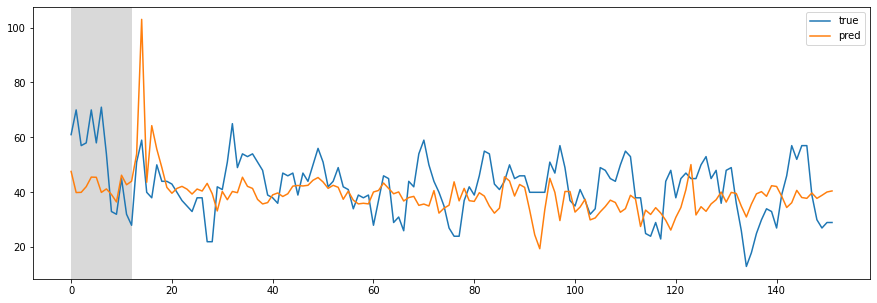

In [86]:
plot_comparison(start_idx=0, length=500, train=False)